<a href="https://colab.research.google.com/github/Austfi/SNOWPACKforPatrollers/blob/dev/RF_Instability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RF Snow Instability Analysis - Model

This notebook analyzes SNOWPACK PRO files using the Random Forest instability model. It automatically downloads and selects the best model version for your Python environment.

## Quick Start

1. **Click "Run all"** in the Runtime menu (or run each cell sequentially with Shift+Enter)
2. **Upload your PRO file** when prompted (or use the example file)
3. **View the results** - plots will appear automatically

## What You Need

- A SNOWPACK PRO file (`.pro` format) - you can upload your own file or use the example
- That's it! Everything else is downloaded automatically.

## What This Notebook Does

- **Single Profile Analysis**: Analyze a specific timestamp from your PRO file
- **Seasonal Evolution**: Track instability probabilities over time
- **CSV Export**: Export daily instability metrics for further analysis

## Important Notes

- `slopeangle` only affects the MF-crust penetration-depth calculation
- `P_unstable` shows layer-wise instability probability (not direct hazard rating)
- Always combine results with field observations before making decisions

## Original Model

Based on the Random Forest snow instability model by:
- **Repository**: [WSL/SLF GitLab - Random Forest Snow Instability Model](https://git.wsl.ch/mayers/random_forest_snow_instability_model.git)
- **Authors**: mayers, fherla (WSL Institute for Snow and Avalanche Research SLF)

## Step 1: Setup Environment

This cell checks your Python environment and prepares the workspace. Just run it - no changes needed!


In [5]:
# Step 1: Setup environment and check Python version
import sys
import platform
import pathlib
import datetime

try:
    import sklearn
    print("Python version:", sys.version.split()[0])
    print("Platform:", platform.system())
    print("scikit-learn version:", sklearn.__version__)
except ImportError:
    print("scikit-learn not found. Installing...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn", "packaging"])
    import sklearn
    print("scikit-learn installed:", sklearn.__version__)

# Setup workspace directory
rf_nb_dir = pathlib.Path.cwd()
rf_dir = (rf_nb_dir / "rf_scripts").resolve()
rf_dir.mkdir(parents=True, exist_ok=True)

# Add to Python path so we can import helper modules
if str(rf_dir) not in sys.path:
    sys.path.insert(0, str(rf_dir))

print(f"\nWorkspace ready: {rf_dir}")
print("Ready to download model files...")


Python version: 3.12.7
Platform: Darwin
scikit-learn version: 1.5.1

Workspace ready: /Users/austinfinnell/Documents/GitHub/SNOWPACKforPatrollers/rf_scripts
Ready to download model files...


## Step 2: Download Model Files

This cell automatically downloads the RF model files from CRAN. It may take 30-60 seconds on first run.


In [6]:
# Step 2: Download and extract RF model files
import tarfile
import urllib.request
import io
import sklearn
import joblib
from packaging import version

rf_inst_py_dir = rf_dir / "inst_python"
rf_inst_py_dir.mkdir(exist_ok=True)

# Check if files already exist (skip download if present)
rf_has_sav_files = len(list(rf_inst_py_dir.glob("*.sav"))) > 0
rf_has_py_modules = (rf_dir / "readProfile.py").exists() and (rf_dir / "pyunstable.py").exists()

if rf_has_sav_files and rf_has_py_modules:
    print("Model files already downloaded - skipping download")
    print(f"Found .sav files in: {rf_inst_py_dir}")
    print(f"Found Python modules in: {rf_dir}")
else:
    print("Downloading model files from CRAN...")
    print("(This may take 30-60 seconds)")
    
    rf_candidates = ["0.4.3", "0.4.2", "0.4.1", "0.4.0"]
    rf_base_live = "https://cran.r-project.org/src/contrib"
    rf_base_archive = "https://cran.r-project.org/src/contrib/Archive/sarp.snowprofile.pyface"
    rf_downloaded = None

    for rf_ver in rf_candidates:
        rf_urls = [
            f"{rf_base_live}/sarp.snowprofile.pyface_{rf_ver}.tar.gz",
            f"{rf_base_archive}/sarp.snowprofile.pyface_{rf_ver}.tar.gz",
        ]
        for rf_url in rf_urls:
            try:
                print(f"Trying: {rf_url.split('/')[-1]}...")
                with urllib.request.urlopen(rf_url, timeout=30) as rf_response:
                    rf_data = rf_response.read()
                rf_downloaded = (rf_ver, rf_data)
                print(f"Downloaded: {rf_url.split('/')[-1]}")
                break
            except Exception as e:
                continue
        if rf_downloaded:
            break

    if rf_downloaded:
        rf_ver, rf_data = rf_downloaded
        print(f"Extracting files from version {rf_ver}...")
        with tarfile.open(fileobj=io.BytesIO(rf_data), mode="r:gz") as rf_tar:
            # Extract .sav model files
            rf_sav_members = [
                m for m in rf_tar.getmembers()
                if m.name.startswith("sarp.snowprofile.pyface/inst/python/") and m.name.endswith(".sav")
            ]
            if rf_sav_members:
                for rf_member in rf_sav_members:
                    rf_target = rf_inst_py_dir / pathlib.Path(rf_member.name).name
                    with rf_tar.extractfile(rf_member) as rf_source:
                        if rf_source is not None:
                            rf_target.write_bytes(rf_source.read())
                print(f"Extracted {len(rf_sav_members)} model file(s)")
            
            # Extract Python helper modules
            rf_py_members = [
                m for m in rf_tar.getmembers()
                if m.name.startswith("sarp.snowprofile.pyface/inst/python/") and m.name.endswith(".py")
            ]
            if rf_py_members:
                for rf_member in rf_py_members:
                    rf_filename = pathlib.Path(rf_member.name).name
                    rf_target = rf_dir / rf_filename
                    if not rf_target.exists():
                        with rf_tar.extractfile(rf_member) as rf_source:
                            if rf_source:
                                rf_target.write_bytes(rf_source.read())
                print(f"Extracted {len(rf_py_members)} Python helper module(s)")
    else:
        print("WARNING: Could not download model files.")
        print("Please upload the files manually or check your internet connection.")
        raise RuntimeError("Failed to download required model files")


Model files already downloaded - skipping download
Found .sav files in: /Users/austinfinnell/Documents/GitHub/SNOWPACKforPatrollers/rf_scripts/inst_python
Found Python modules in: /Users/austinfinnell/Documents/GitHub/SNOWPACKforPatrollers/rf_scripts


## Step 3: Load Model

This cell automatically selects and loads the best RF model for your scikit-learn version.


In [ ]:
# Step 3: Load Model and Import Modules
import glob
import re
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import helper modules
import readProfile
import get_RF
import plt_RF

# Reload modules to ensure latest code is used
importlib.reload(plt_RF)

# Select best model for scikit-learn version
def select_model_path(inst_dir, skl_ver):
    files = sorted(glob.glob(str(inst_dir / "*.sav")))
    if not files:
        return None, "No .sav files present."
    
    v = version.parse(skl_ver)
    # Preference ordering
    if v >= version.parse("1.5"):
        prefs = ["scikit152", "scikit121", "published_2022"]
    elif v >= version.parse("1.2"):
        prefs = ["scikit121", "scikit152", "published_2022"]
    else:
        prefs = ["published_2022", "scikit121", "scikit152"]
    
    for key in prefs:
        for f in files:
            if key in pathlib.Path(f).name:
                return pathlib.Path(f), None
    # Fallback: any .sav
    return pathlib.Path(files[-1]), "Heuristic fallback: picked the last available .sav"

# Load model
skl_ver = sklearn.__version__
MODEL_PATH = None
WARN = None

if rf_inst_py_dir.exists():
    MODEL_PATH, WARN = select_model_path(rf_inst_py_dir, skl_ver)
    if MODEL_PATH is None:
        MODEL_PATH, WARN = select_model_path(rf_dir, skl_ver)

if MODEL_PATH is None:
    raise RuntimeError("No model file found. Please run Step 2 first.")

print("scikit-learn:", skl_ver)
print("Chosen model:", MODEL_PATH.name)
if WARN:
    print("Note:", WARN)

# Try loading
try:
    rf_model = joblib.load(MODEL_PATH)
    print("Model loaded successfully!")
except Exception as e:
    raise RuntimeError(f"Failed to load model: {e}")



Please set rf_pro_file_path in the previous cell first!


In [ ]:
## Step 4: Upload PRO File (Optional - Google Colab)

If you're using Google Colab, upload your PRO file here. Otherwise, skip to Step 6.



NameError: name 'pd' is not defined

# Step 4: Upload PRO File (Optional - Google Colab)
try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("Upload your PRO file:")
    uploaded = files.upload()
    if uploaded:
        # Get the first uploaded file
        rf_pro_file_path = list(uploaded.keys())[0]
        print(f"Uploaded: {rf_pro_file_path}")
    else:
        rf_pro_file_path = None
        print("No file uploaded. You can set the path manually in Step 6.")
else:
    print("Not in Google Colab. Skip to Step 6 to set your PRO file path.")
    rf_pro_file_path = None


In [ ]:
# Step 6: Set PRO file path
# Edit this path if you didn't use the upload widget above

# Check if file was uploaded in previous cell
if 'rf_pro_file_path' not in globals() or rf_pro_file_path is None:
    # Try to find example file, or set your path here
    rf_pro_file_path = None
    rf_example_candidates = [
        pathlib.Path("snowprofiles/WFJ2_2017.pro"),
        pathlib.Path("input_example/WFJ2_2017.pro"),
        pathlib.Path("/content/WFJ2_2017.pro"),  # Colab default
        pathlib.Path(rf_dir / "WFJ2_2017.pro"),  # Uploaded file location
    ]

    for rf_candidate in rf_example_candidates:
        if rf_candidate.exists():
            rf_pro_file_path = str(rf_candidate)
            print(f"Found PRO file: {rf_pro_file_path}")
            break

    if rf_pro_file_path is None:
        # User needs to set the path manually
        rf_pro_file_path = ""  # EDIT THIS: e.g., "/content/my_file.pro" or "snowprofiles/mysite.pro"
        print("No PRO file found automatically.")
        print("Please edit rf_pro_file_path in this cell to point to your PRO file.")
        print("Example: rf_pro_file_path = '/content/my_snowprofile.pro'")
else:
    print(f"Using uploaded file: {rf_pro_file_path}")

# Helper function to normalize P_unstable values
def rf_fix_punstable(df: pd.DataFrame, column: str = 'P_unstable') -> pd.DataFrame:
    """Ensure instability probabilities are in [0, 1] range."""
    if column not in df.columns:
        return df
    rf_vals = pd.to_numeric(df[column], errors='coerce')
    rf_valid = rf_vals.dropna()
    if len(rf_valid) == 0:
        return df
    rf_min, rf_max = float(rf_valid.min()), float(rf_valid.max())
    if rf_max <= 1.0 + 1e-6 and rf_min >= -1e-6:
        df[column] = rf_vals.clip(0.0, 1.0)
    elif rf_max <= 100.0 and rf_min >= 0.0:
        df[column] = (rf_vals / 100.0).clip(0.0, 1.0)
    else:
        df[column] = rf_vals.clip(0.0, 1.0)
    return df



Using uploaded file: snowprofiles/WFJ2_2017.pro


## Step 7: Single Profile Analysis

Analyze a specific timestamp from your PRO file. Change the date/time below to analyze different profiles.


Reading profile from: snowprofiles/WFJ2_2017.pro
Reading file:  snowprofiles/WFJ2_2017.pro
Computing instability probabilities...
Creating plot...


/var/folders/dw/vcqly2fd4_qdr4dz5rr616q80000gn/T/ipykernel_74110/2528813520.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


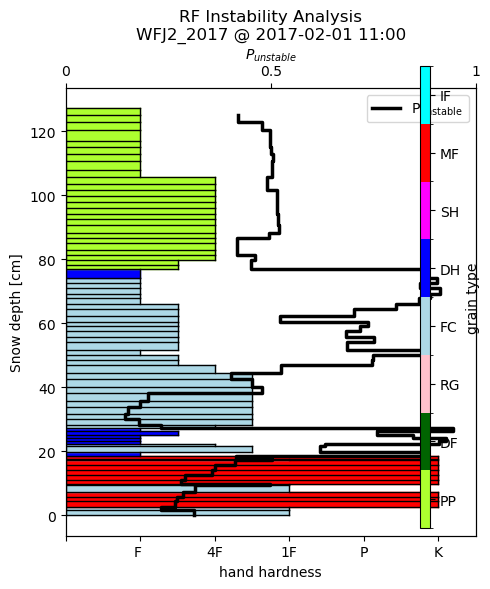

Analysis complete!
Layers analyzed: 74
P_unstable range: 0.145 - 0.944


In [ ]:
# Step 7: Analyze a single profile
# EDIT THESE VALUES TO ANALYZE YOUR PROFILE:

rf_timestamp = datetime.datetime(2017, 2, 1, 11, 0)  # Year, Month, Day, Hour, Minute
rf_slopeangle = 0  # Slope angle in degrees (affects penetration depth calculation)

# Check if PRO file is set
if not rf_pro_file_path or rf_pro_file_path == "":
    print("Please set rf_pro_file_path in the previous cell first!")
elif not pathlib.Path(rf_pro_file_path).exists():
    print(f"File not found: {rf_pro_file_path}")
    print("Please check the path and try again.")
else:
    try:
        # Read profile
        print(f"Reading profile from: {rf_pro_file_path}")
        rf_profile = readProfile.read_profile(rf_pro_file_path, rf_timestamp, remove_soil=True)
        
        # Compute RF features and P_unstable
        print("Computing instability probabilities...")
        rf_df_profile = get_RF.create_RFprof(rf_profile, rf_slopeangle, rf_model)
        rf_df_profile = rf_fix_punstable(rf_df_profile)
        
        # Plot results
        print("Creating plot...")
        rf_fig, rf_ax = plt.subplots(figsize=(5, 6))
        plt_RF.plot_sp_single_P0(rf_fig, rf_ax, rf_df_profile, var='P_unstable', colorbar=True)
        rf_ax.set_title(f"RF Instability Analysis\n{pathlib.Path(rf_pro_file_path).stem} @ {rf_timestamp.strftime('%Y-%m-%d %H:%M')}")
        plt.tight_layout()
        plt.show()
        
        print("Analysis complete!")
        print(f"Layers analyzed: {len(rf_df_profile)}")
        print(f"P_unstable range: {rf_df_profile['P_unstable'].min():.3f} - {rf_df_profile['P_unstable'].max():.3f}")
        
    except Exception as e:
        print(f"Error analyzing profile: {e}")
        print("Please check:")
        print("1. The PRO file path is correct")
        print("2. The timestamp exists in your PRO file")
        print("3. The file format is correct")
        raise


## 📈 Step 8: Seasonal Evolution

Track instability probabilities over time. Edit the date range below to analyze different periods.


Reading all profiles from: snowprofiles/WFJ2_2017.pro
Reading file:  snowprofiles/WFJ2_2017.pro
Analyzing profiles from 2016-12-01 to 2017-04-01...
Found 122 days with profile data
Creating seasonal evolution plot...


/var/folders/dw/vcqly2fd4_qdr4dz5rr616q80000gn/T/ipykernel_74110/3724930044.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


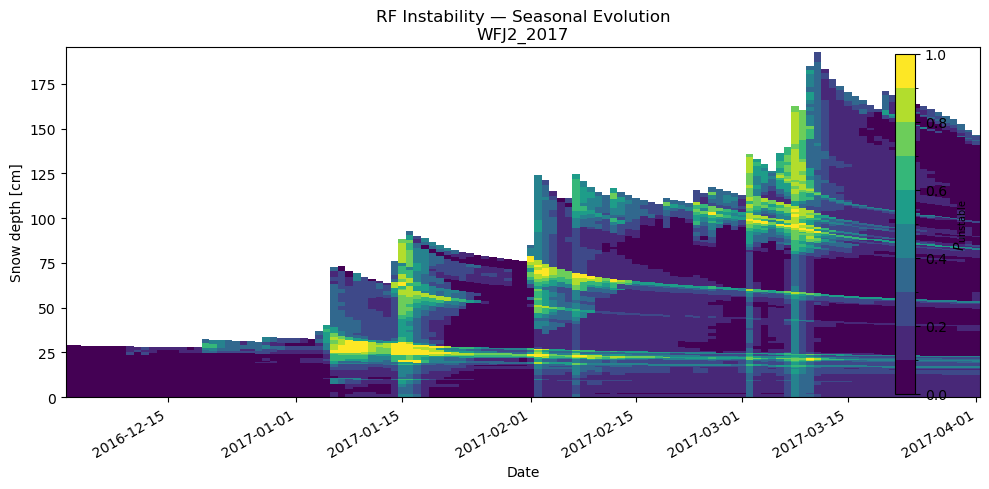

Seasonal evolution plot complete!


In [ ]:
# Step 8: Seasonal evolution analysis
# EDIT THESE VALUES TO CHANGE THE DATE RANGE:

rf_year = 2017  # Year to analyze
rf_start = pd.Timestamp(rf_year - 1, 12, 1, 12, 0)  # Start: Dec 1 of previous year
rf_stop = pd.Timestamp(rf_year, 4, 1, 12, 0)  # Stop: Apr 1 of analysis year
rf_slopeangle = 0  # Slope angle in degrees

# Check if PRO file is set
if not rf_pro_file_path or rf_pro_file_path == "":
    print("Please set rf_pro_file_path in Step 6 first!")
elif not pathlib.Path(rf_pro_file_path).exists():
    print(f"File not found: {rf_pro_file_path}")
else:
    try:
        print(f"Reading all profiles from: {rf_pro_file_path}")
        rf_profiles_all = readProfile.read_profile(rf_pro_file_path, remove_soil=True)
        rf_profiles_data = rf_profiles_all.get('data', {}) if isinstance(rf_profiles_all, dict) else {}
        
        print(f"Analyzing profiles from {rf_start.date()} to {rf_stop.date()}...")
        rf_dates = pd.date_range(rf_start, rf_stop, freq='D')
        rf_rows = []
        
        for rf_ts in rf_dates:
            rf_profile_daily = rf_profiles_data.get(rf_ts)
            if rf_profile_daily is None or len(rf_profile_daily.get('height', [])) == 0:
                continue
            rf_df_daily = get_RF.create_RFprof(rf_profile_daily, rf_slopeangle, rf_model)
            rf_df_daily = rf_fix_punstable(rf_df_daily)
            if 'layer_top' in rf_df_daily:
                rf_df_daily['HS'] = rf_df_daily['layer_top'].iloc[-1]
            rf_df_daily.insert(0, 'datetime', rf_ts)
            rf_rows.append(rf_df_daily)
        
        if rf_rows:
            rf_evo = pd.concat(rf_rows, ignore_index=True)
            rf_evo = rf_evo.sort_values(['datetime', 'layer_top']).reset_index(drop=True)
            rf_unique_days = rf_evo['datetime'].nunique()
            
            print(f"Found {rf_unique_days} days with profile data")
            
            if rf_unique_days >= 2:
                print("Creating seasonal evolution plot...")
                rf_fig_evo, rf_ax_evo = plt.subplots(figsize=(10, 5))
                plt_RF.plot_evo_SP(rf_evo, rf_fig_evo, rf_ax_evo, rf_start, rf_stop, 
                                  var='P_unstable', colorbar=True, resolution='D')
                rf_ax_evo.set_title(f"RF Instability — Seasonal Evolution\n{pathlib.Path(rf_pro_file_path).stem}")
                plt.tight_layout()
                plt.show()
                print("Seasonal evolution plot complete!")
            else:
                print(f"Need at least 2 days of data. Found {rf_unique_days} day(s).")
                print("Try adjusting rf_start and rf_stop dates.")
        else:
            print(f"No profiles found between {rf_start.date()} and {rf_stop.date()}")
            print("Try adjusting the date range or check your PRO file.")
        
    except Exception as e:
        print(f"Error in seasonal analysis: {e}")
        raise


## Step 9: Export Results (Optional)

Export daily instability metrics to a CSV file for further analysis.


In [ ]:
# Step 9: Export results to CSV (Optional)
# This creates a CSV file with daily maximum P_unstable values and depths

if 'rf_pro_file_path' not in globals() or not rf_pro_file_path or rf_pro_file_path == "":
    print("Skipping CSV export - no PRO file set")
else:
    try:
        # Use same settings as seasonal evolution, or customize:
        rf_export_year = 2017
        rf_export_start = pd.Timestamp(rf_export_year - 1, 12, 1, 12, 0)
        rf_export_stop = pd.Timestamp(rf_export_year, 4, 1, 12, 0)
        rf_export_slope = 0
        
        print("Computing daily statistics...")
        rf_profiles_all = readProfile.read_profile(rf_pro_file_path, remove_soil=True)
        rf_profiles_data = rf_profiles_all.get('data', {}) if isinstance(rf_profiles_all, dict) else {}
        
        rf_rows_export = []
        for rf_day in pd.date_range(rf_export_start, rf_export_stop, freq='D'):
            rf_profile_day = rf_profiles_data.get(rf_day)
            if not rf_profile_day or len(rf_profile_day.get('height', [])) == 0:
                continue
            rf_df_day = get_RF.create_RFprof(rf_profile_day, rf_export_slope, rf_model)
            rf_df_day = rf_fix_punstable(rf_df_day)
            rf_rows_export.append({
                'datetime': rf_day,
                'HS': float(rf_df_day['layer_top'].iloc[-1]) if 'layer_top' in rf_df_day else float('nan'),
                'P_unstable_max': float(rf_df_day['P_unstable'].max()),
                'z_Pmax': float(rf_df_day.loc[rf_df_day['P_unstable'].idxmax(), 'layer_top']) if 'layer_top' in rf_df_day else float('nan')
            })
        
        if rf_rows_export:
            rf_out_df = pd.DataFrame(rf_rows_export).sort_values('datetime')
            rf_out_csv = rf_dir / "p_unstable_daily.csv"
            rf_out_df.to_csv(rf_out_csv, index=False)
            
            print(f"CSV file created: {rf_out_csv}")
            print(f"Rows: {len(rf_out_df)}")
            print("\nFirst few rows:")
            from IPython.display import display
            display(rf_out_df.head())
            
            # In Colab, offer download
            try:
                from google.colab import files
                print("\n Downloading CSV file...")
                files.download(str(rf_out_csv))
            except ImportError:
                print(f"\n File saved to: {rf_out_csv}")
        else:
            print("No data to export. Check date range and PRO file.")
        
    except Exception as e:
        print(f"Error exporting CSV: {e}")
        raise


Computing daily statistics...
Reading file:  snowprofiles/WFJ2_2017.pro
CSV file created: /Users/austinfinnell/Documents/GitHub/SNOWPACKforPatrollers/rf_scripts/p_unstable_daily.csv
Rows: 122

First few rows:


,datetime,HS,P_unstable_max,z_Pmax
0,2016-12-01 12:00:00,31.62,0.054458,24.29
1,2016-12-02 12:00:00,31.55,0.070000,25.61
2,2016-12-03 12:00:00,31.37,0.039583,24.12
3,2016-12-04 12:00:00,31.31,0.042083,24.07
4,2016-12-05 12:00:00,31.26,0.070833,28.68



 File saved to: /Users/austinfinnell/Documents/GitHub/SNOWPACKforPatrollers/rf_scripts/p_unstable_daily.csv


## Notes

- **File format**: This notebook reads SNOWPACK PRO files compatible with the [sarp.snowprofile R package](https://cran.r-project.org/web/packages/sarp.snowprofile/) format specification.

- **Model selection**: The notebook automatically selects the best RF model for your scikit-learn version. If you get unpickling errors, you may need to temporarily install a specific scikit-learn version.

- **Interpreting results**: 
 - `P_unstable` indicates layer-wise instability probability (0 = stable, 1 = unstable)
 - Always combine with field observations before making decisions
 - `slopeangle` only affects penetration depth calculations, not the core model

- **Troubleshooting**:
 - If file upload doesn't work, use the file path method instead
 - If dates aren't found, check what timestamps are available in your PRO file
 - If plots don't appear, make sure matplotlib is working: `plt.show()` should display plots
